 Dataset loaded successfully!
Train samples: 496, Test samples: 124
Features: ['N', 'P', 'K', 'pH', 'EC']

 Logistic Regression trained successfully!
Accuracy: 0.976

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.97      0.97      0.97        35
           2       0.95      0.97      0.96        36

    accuracy                           0.98       124
   macro avg       0.97      0.97      0.97       124
weighted avg       0.98      0.98      0.98       124




SHAP type: <class 'numpy.ndarray'>
SHAP array shape: (124, 5, 3)
X_test_scaled shape: (124, 5)
 Fixed mean_abs_shap shape: (5,)

 Global SHAP Feature Importance:
  Feature  Mean |SHAP|
1       P     1.461546
4      EC     1.243878
2       K     1.064131
0       N     1.012736
3      pH     0.910372


/Users/aarush/projects/soil-health-ml/.venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


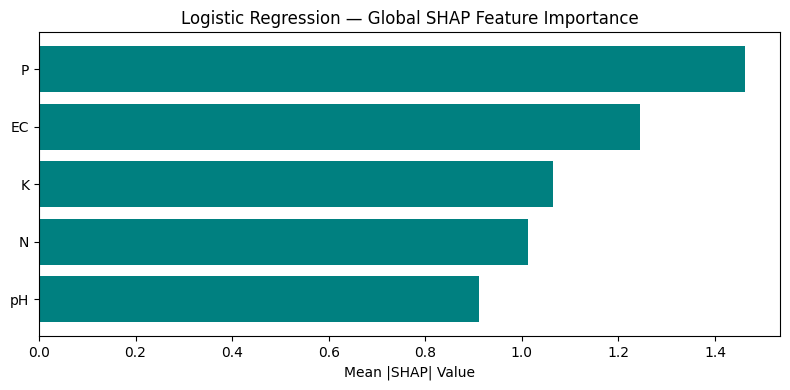

 Saved Global SHAP bar plot → ../images/shap/shap_global_bar_logistic.png


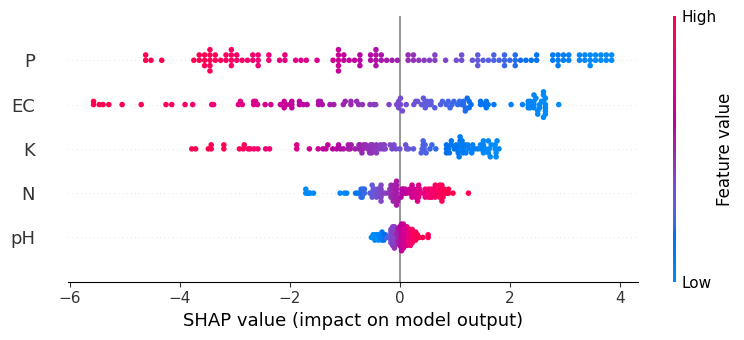

 Saved SHAP Beeswarm plot → ../images/shap/shap_beeswarm_logistic.png

Creating dependence plot for: P vs EC


<Figure size 640x480 with 0 Axes>

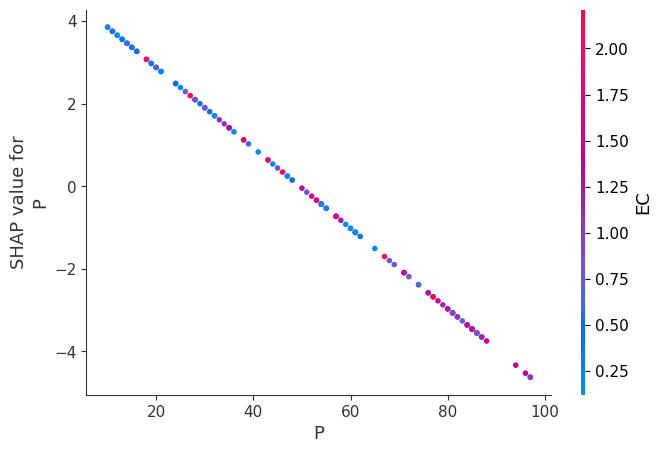

 Saved SHAP dependence plot → ../images/shap/shap_dependence_P_vs_EC.png

Explaining sample index: 10
Predicted class: 0
Probabilities: [9.99039839e-01 5.14214270e-04 4.45946378e-04]

 All SHAP plots generated and saved successfully.


In [140]:
# ==========================================
#  Logistic Regression + SHAP Explainability (Final Stable Version)
#  Dataset: soil_data_clustered.csv
#  Saves plots into ../images/shap/
# ==========================================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------
#  Load Dataset
# ------------------------------------------
df = pd.read_csv("../data/clean/soil_data_clustered.csv")

# Features and target
X = df.drop(columns=["Cluster"])
y = df["Cluster"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(" Dataset loaded successfully!")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Features:", X.columns.tolist())

# ------------------------------------------
#  Scaling
# ------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------
#  Train Logistic Regression
# ------------------------------------------
log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# Accuracy & classification report
acc = accuracy_score(y_test, y_pred)
print(f"\n Logistic Regression trained successfully!")
print(f"Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# ------------------------------------------
#  SHAP Explainability
# ------------------------------------------
shap.initjs()

explainer = shap.LinearExplainer(
    log_reg,
    X_train_scaled,
    feature_perturbation="interventional"  # deprecated but stable
)
shap_values = explainer.shap_values(X_test_scaled)

print("\nSHAP type:", type(shap_values))
print("SHAP array shape:", np.array(shap_values).shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# ------------------------------------------
#  Aggregate SHAP Values
# ------------------------------------------
shap_array = np.array(shap_values)

# Handle multi-class (samples × features × classes)
if shap_array.ndim == 3:
    shap_abs = np.abs(shap_array)
    mean_abs_shap = np.mean(shap_abs, axis=(0, 2))
else:
    mean_abs_shap = np.mean(np.abs(shap_array), axis=0)

print(" Fixed mean_abs_shap shape:", mean_abs_shap.shape)

# ------------------------------------------
#  Global SHAP Feature Importance
# ------------------------------------------
shap_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean |SHAP|": mean_abs_shap
}).sort_values(by="Mean |SHAP|", ascending=False)

print("\n Global SHAP Feature Importance:")
print(shap_importance_df)

# ==========================================
#  Create Folder to Save Plots
# ==========================================
save_dir = "../images/shap"
os.makedirs(save_dir, exist_ok=True)

# ==========================================
#  Plot 1 — Global SHAP Bar Plot
# ==========================================
plt.figure(figsize=(8, 4))
plt.barh(shap_importance_df["Feature"], shap_importance_df["Mean |SHAP|"], color="teal")
plt.gca().invert_yaxis()
plt.title("Logistic Regression — Global SHAP Feature Importance", fontsize=12)
plt.xlabel("Mean |SHAP| Value")
plt.tight_layout()

bar_plot_path = os.path.join(save_dir, "shap_global_bar_logistic.png")
plt.savefig(bar_plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved Global SHAP bar plot → {bar_plot_path}")

# ==========================================
#  Plot 2 — SHAP Beeswarm Plot
# ==========================================
plt.figure()
if shap_array.ndim == 3:
    shap.summary_plot(shap_array[:, :, 0], X_test, feature_names=X.columns, show=False)
else:
    shap.summary_plot(shap_array, X_test, feature_names=X.columns, show=False)

beeswarm_path = os.path.join(save_dir, "shap_beeswarm_logistic.png")
plt.savefig(beeswarm_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved SHAP Beeswarm plot → {beeswarm_path}")

# ==========================================
# Plot 3 — SHAP Dependence Plot
# ==========================================
top_feature = shap_importance_df["Feature"].iloc[0]
second_feature = shap_importance_df["Feature"].iloc[1]
print(f"\nCreating dependence plot for: {top_feature} vs {second_feature}")

plt.figure()
if shap_array.ndim == 3:
    shap.dependence_plot(
        top_feature,
        shap_array[:, :, 0],
        X_test,
        feature_names=X.columns,
        interaction_index=second_feature,
        show=False
    )
else:
    shap.dependence_plot(
        top_feature,
        shap_array,
        X_test,
        feature_names=X.columns,
        interaction_index=second_feature,
        show=False
    )

dependence_path = os.path.join(save_dir, f"shap_dependence_{top_feature}_vs_{second_feature}.png")
plt.savefig(dependence_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved SHAP dependence plot → {dependence_path}")

# ------------------------------------------
# Local SHAP Force Plot (optional HTML view)
# ------------------------------------------
sample_index = 10
sample = X_test_scaled[sample_index:sample_index + 1]

pred_class = log_reg.predict(sample)[0]
pred_probs = log_reg.predict_proba(sample)[0]

print(f"\nExplaining sample index: {sample_index}")
print(f"Predicted class: {pred_class}")
print(f"Probabilities: {pred_probs}")

if shap_array.ndim == 3:
    shap.force_plot(
        explainer.expected_value[pred_class],
        shap_array[sample_index, :, pred_class],
        X_test.iloc[sample_index],
        feature_names=X.columns
    )
else:
    shap.force_plot(
        explainer.expected_value,
        shap_array[sample_index],
        X_test.iloc[sample_index],
        feature_names=X.columns
    )

print("\n All SHAP plots generated and saved successfully.")


In [125]:
print("SHAP type:", type(shap_values))

if isinstance(shap_values, list):
    print(f"Number of classes: {len(shap_values)}")
    print(f"Shape of first class SHAP array: {shap_values[0].shape}")
    print(f"Shape of last class SHAP array: {shap_values[-1].shape}")
else:
    print(f"SHAP array shape: {shap_values.shape}")

print("X_test_scaled shape:", X_test_scaled.shape)


SHAP type: <class 'numpy.ndarray'>
SHAP array shape: (124, 5, 3)
X_test_scaled shape: (124, 5)


 Dataset loaded successfully!
Train samples: 496, Test samples: 124
Features: ['N', 'P', 'K', 'pH', 'EC']

 Random Forest trained successfully!
Accuracy: 0.944

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.94      0.97      0.96        35
           2       0.91      0.89      0.90        36

    accuracy                           0.94       124
   macro avg       0.94      0.94      0.94       124
weighted avg       0.94      0.94      0.94       124




SHAP type: <class 'numpy.ndarray'>
SHAP array shape: (124, 5, 3)
X_test_scaled shape: (124, 5)
 Fixed SHAP array shape: (124, 5, 3)
mean_abs_shap shape: (5,)

 Global SHAP Feature Importance:
  Feature  Mean |SHAP|
4      EC     0.130980
2       K     0.121025
1       P     0.096830
3      pH     0.091454
0       N     0.051735


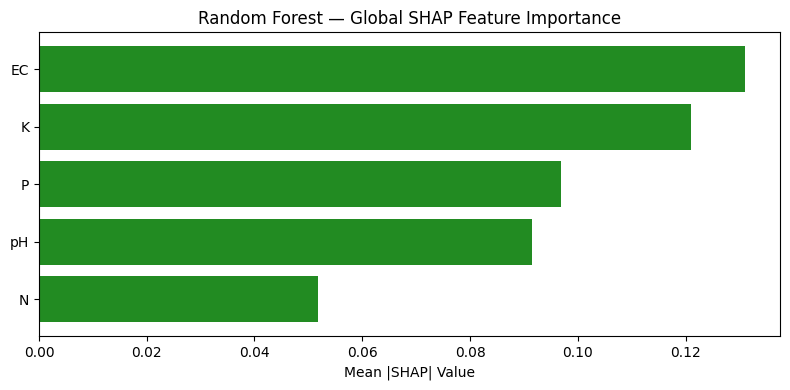

 Saved Global SHAP bar plot → ../images/shap_rf/shap_rf_global_bar.png


<Figure size 640x480 with 0 Axes>

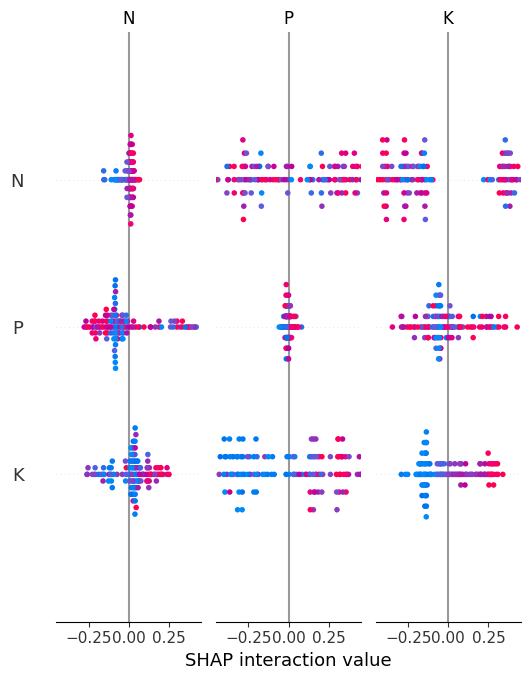

 Saved SHAP Beeswarm plot → ../images/shap_rf/shap_rf_beeswarm.png

Creating dependence plot for top feature: EC vs K


<Figure size 640x480 with 0 Axes>

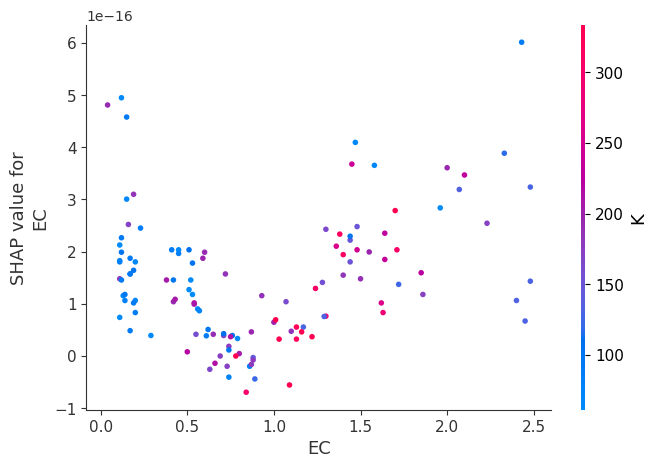

 Saved SHAP dependence plot → ../images/shap_rf/shap_rf_dependence_EC_vs_K.png

 Explaining sample index: 20
Predicted class: 0
Probabilities: [0.98 0.   0.02]


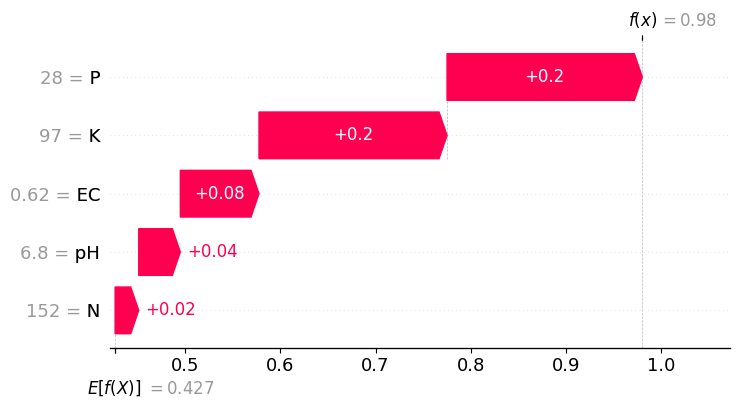

 Saved Local SHAP Waterfall plot → ../images/shap_rf/shap_rf_waterfall_sample_20.png

 All Random Forest SHAP plots generated and saved successfully.
 Folder: /Users/aarush/projects/soil-health-ml/images/shap_rf


In [143]:
# ==========================================
#  Random Forest + SHAP Explainability (Final Stable Version)
#  Dataset: soil_data_clustered.csv
#  Saves all plots into ../images/shap_rf/
# ==========================================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------
#  Load Dataset
# ------------------------------------------
df = pd.read_csv("../data/clean/soil_data_clustered.csv")

# Separate features and target
X = df.drop(columns=["Cluster"])
y = df["Cluster"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(" Dataset loaded successfully!")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Features:", X.columns.tolist())

# ------------------------------------------
#  Scaling (optional for Random Forest)
# ------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------
#  Train Random Forest Classifier
# ------------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Model evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n Random Forest trained successfully!")
print(f"Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# ------------------------------------------
#  SHAP Explainability
# ------------------------------------------
shap.initjs()
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

print("\nSHAP type:", type(shap_values_rf))
if isinstance(shap_values_rf, list):
    print(f"Number of classes: {len(shap_values_rf)}")
    print(f"Shape of first SHAP array: {shap_values_rf[0].shape}")
else:
    print("SHAP array shape:", shap_values_rf.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# ------------------------------------------
#  Fix Multiclass SHAP Shape
# ------------------------------------------
if isinstance(shap_values_rf, list):
    shap_array = np.array(shap_values_rf)  # (classes, samples, features)
    shap_array = np.transpose(shap_array, (1, 2, 0))  # → (samples, features, classes)
else:
    shap_array = np.array(shap_values_rf)

print(" Fixed SHAP array shape:", shap_array.shape)

# Take absolute SHAP values and average across samples & classes
mean_abs_shap = np.mean(np.abs(shap_array), axis=(0, 2))
print("mean_abs_shap shape:", mean_abs_shap.shape)

# ------------------------------------------
# Global SHAP Feature Importance
# ------------------------------------------
shap_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean |SHAP|": mean_abs_shap
}).sort_values(by="Mean |SHAP|", ascending=False)

print("\n Global SHAP Feature Importance:")
print(shap_importance_df)

# ------------------------------------------
#  Create Folder to Save Plots
# ------------------------------------------
save_dir = "../images/shap_rf"
os.makedirs(save_dir, exist_ok=True)

# ------------------------------------------
#  Plot 1 — Global SHAP Bar Plot
# ------------------------------------------
plt.figure(figsize=(8, 4))
plt.barh(shap_importance_df["Feature"], shap_importance_df["Mean |SHAP|"], color="forestgreen")
plt.gca().invert_yaxis()
plt.title("Random Forest — Global SHAP Feature Importance", fontsize=12)
plt.xlabel("Mean |SHAP| Value")
plt.tight_layout()

bar_path = os.path.join(save_dir, "shap_rf_global_bar.png")
plt.savefig(bar_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved Global SHAP bar plot → {bar_path}")

# ------------------------------------------
# Plot 2 — SHAP Beeswarm Plot
# ------------------------------------------
plt.figure()
if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[0], X_test, feature_names=X.columns, show=False)
else:
    shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, show=False)

beeswarm_path = os.path.join(save_dir, "shap_rf_beeswarm.png")
plt.savefig(beeswarm_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved SHAP Beeswarm plot → {beeswarm_path}")

# ------------------------------------------
#Plot 3 — SHAP Dependence Plot
# ------------------------------------------
top_feature = shap_importance_df["Feature"].iloc[0]
second_feature = shap_importance_df["Feature"].iloc[1]
print(f"\nCreating dependence plot for top feature: {top_feature} vs {second_feature}")

# Handle different SHAP structures
if isinstance(shap_values_rf, list):
    shap_vals_for_plot = shap_values_rf[0]  # class 0
elif shap_array.ndim == 3:
    shap_vals_for_plot = np.mean(shap_array, axis=2)
else:
    shap_vals_for_plot = shap_values_rf

plt.figure()
shap.dependence_plot(
    top_feature,
    shap_vals_for_plot,
    X_test,
    feature_names=X.columns,
    interaction_index=second_feature,
    show=False
)

dependence_path = os.path.join(save_dir, f"shap_rf_dependence_{top_feature}_vs_{second_feature}.png")
plt.savefig(dependence_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved SHAP dependence plot → {dependence_path}")

# ------------------------------------------
#  Plot 4 — Local SHAP Waterfall Plot
# ------------------------------------------
sample_index = 20
sample = X_test_scaled[sample_index:sample_index + 1]

pred_class = rf.predict(sample)[0]
pred_probs = rf.predict_proba(sample)[0]

print(f"\n Explaining sample index: {sample_index}")
print(f"Predicted class: {pred_class}")
print(f"Probabilities: {pred_probs}")

# Compute SHAP values for this sample
sample_shap = explainer_rf.shap_values(sample)

# Handle multiclass output correctly
if isinstance(sample_shap, list):
    shap_values_matrix = np.array(sample_shap[pred_class])[0]  # (5,)
else:
    shap_values_matrix = np.array(sample_shap[0])
    if shap_values_matrix.ndim == 2 and shap_values_matrix.shape[1] > 1:
        shap_values_matrix = shap_values_matrix[:, pred_class]

base_value = explainer_rf.expected_value[pred_class]

# Create explanation object
sample_explanation = shap.Explanation(
    values=shap_values_matrix,
    base_values=base_value,
    data=X_test.iloc[sample_index],
    feature_names=X.columns
)

# Save waterfall plot
plt.figure()
shap.plots.waterfall(sample_explanation, max_display=10, show=False)

waterfall_path = os.path.join(save_dir, f"shap_rf_waterfall_sample_{sample_index}.png")
plt.savefig(waterfall_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Saved Local SHAP Waterfall plot → {waterfall_path}")

# ------------------------------------------
print("\n All Random Forest SHAP plots generated and saved successfully.")
print(f" Folder: {os.path.abspath(save_dir)}")


 LIME HTML explanation saved → ../images/lime_plot_logistic/lime_logistic_sample_86.html

 Feature contributions (LIME weights) for sample #86:
 - EC > 0.78: 0.442
 - -0.02 < pH <= 0.55: -0.099
 - K > 0.55: -0.092
 - P > 0.87: 0.067
 - -0.65 < N <= 0.09: 0.004


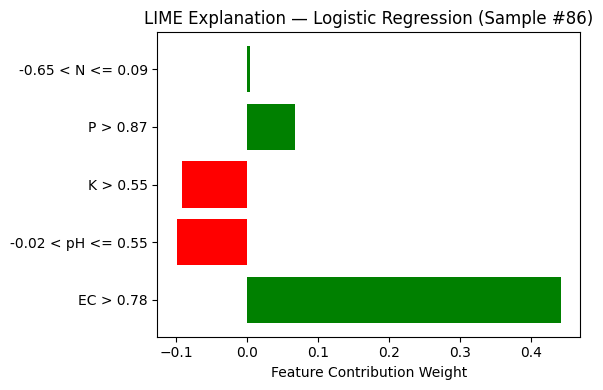

LIME bar plot saved → ../images/lime_plot_logistic/lime_logistic_bar_sample_86.png

All LIME outputs (HTML + plot) generated and saved successfully.


In [145]:
# ==========================================
#  LIME EXPLANATION + BAR PLOT — Logistic Regression (Final Stable Version)
#  Saves plots in ../images/lime_logistic/
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ------------------------------------------
#  Load Dataset & Train Model (if not already)
# ------------------------------------------
if 'log_reg' not in locals():
    df_clustered = pd.read_csv("../data/clean/soil_data_clustered.csv")
    X = df_clustered[['N', 'P', 'K', 'pH', 'EC']]
    y = df_clustered['Cluster']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(max_iter=2000, random_state=42)
    log_reg.fit(X_train_scaled, y_train)
    print(" Logistic Regression trained successfully!")

# ------------------------------------------
#  Initialize LIME Explainer
# ------------------------------------------
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in np.unique(y_train)],
    mode='classification'
)

# ------------------------------------------
#  Select Sample to Explain
# ------------------------------------------
sample_index = 86  # can be any valid test index
sample = X_test_scaled[sample_index]

# ------------------------------------------
#  Generate LIME Explanation
# ------------------------------------------
lime_exp = lime_explainer.explain_instance(
    data_row=sample,
    predict_fn=log_reg.predict_proba
)

# ------------------------------------------
#  Create Save Directory
# ------------------------------------------
save_dir = "../images/lime_plot_logistic"
os.makedirs(save_dir, exist_ok=True)

# ------------------------------------------
# Save HTML Explanation
# ------------------------------------------
html_path = os.path.join(save_dir, f"lime_logistic_sample_{sample_index}.html")
lime_exp.save_to_file(html_path)
print(f" LIME HTML explanation saved → {html_path}")

# ------------------------------------------
#  Display and Save Feature Contributions as Bar Plot
# ------------------------------------------
lime_weights = lime_exp.as_list()

print(f"\n Feature contributions (LIME weights) for sample #{sample_index}:")
for feat, weight in lime_weights:
    print(f" - {feat}: {weight:.3f}")

# Prepare bar chart
plt.figure(figsize=(6, 4))
colors = ['green' if w > 0 else 'red' for _, w in lime_weights]
plt.barh([f for f, _ in lime_weights], [w for _, w in lime_weights], color=colors)
plt.xlabel("Feature Contribution Weight")
plt.title(f"LIME Explanation — Logistic Regression (Sample #{sample_index})")
plt.tight_layout()

# Save bar chart
plot_path = os.path.join(save_dir, f"lime_logistic_bar_sample_{sample_index}.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"LIME bar plot saved → {plot_path}")
print("\nAll LIME outputs (HTML + plot) generated and saved successfully.")


 LIME explanation saved → ../images/lime_rf/lime_rf_sample_50.html

 Feature contributions (LIME weights) for Random Forest — sample #50:
 - EC > 0.78: 0.414
 - pH <= -0.60: 0.303
 - N <= -0.65: 0.239
 - -0.90 < P <= 0.05: -0.005
 - K <= -0.91: 0.002


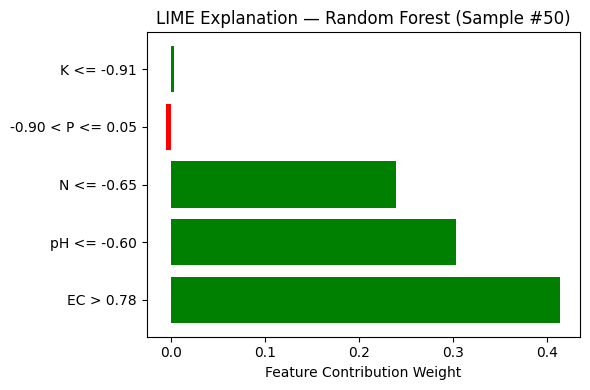

 LIME bar plot saved → ../images/lime_rf/lime_rf_bar_sample_50.png
 LIME weights CSV saved → ../images/lime_rf/lime_rf_weights_sample_50.csv

 All LIME Random Forest outputs (HTML + plot + CSV) saved successfully.
 Folder: /Users/aarush/projects/soil-health-ml/images/lime_rf


In [146]:
# ==========================================
#  LIME EXPLANATION + BAR PLOT — Random Forest (Final Stable Version)
#  Saves all outputs in ../images/lime_rf/
# ==========================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------------------------------------
# Load Dataset & Train Random Forest (if not already in memory)
# ------------------------------------------
if 'rf' not in locals():
    df_clustered = pd.read_csv("../data/clean/soil_data_clustered.csv")
    X = df_clustered[['N', 'P', 'K', 'pH', 'EC']]
    y = df_clustered['Cluster']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train_scaled, y_train)
    print(" Random Forest trained successfully!")

# ------------------------------------------
# Initialize LIME Explainer
# ------------------------------------------
lime_explainer_rf = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in np.unique(y_train)],
    mode='classification'
)

# ------------------------------------------
#  Pick a Test Sample
# ------------------------------------------
sample_index = 50  # choose your sample index
sample = X_test_scaled[sample_index]

# ------------------------------------------
#  Generate LIME Explanation
# ------------------------------------------
lime_exp_rf = lime_explainer_rf.explain_instance(
    data_row=sample,
    predict_fn=rf.predict_proba
)

# ------------------------------------------
#  Create Save Directory
# ------------------------------------------
save_dir = "../images/lime_rf"
os.makedirs(save_dir, exist_ok=True)

# ------------------------------------------
#  Save Interactive HTML Explanation
# ------------------------------------------
html_path = os.path.join(save_dir, f"lime_rf_sample_{sample_index}.html")
lime_exp_rf.save_to_file(html_path)
print(f" LIME explanation saved → {html_path}")

# ------------------------------------------
#  Display & Save LIME Feature Contributions
# ------------------------------------------
lime_weights_rf = lime_exp_rf.as_list()
print(f"\n Feature contributions (LIME weights) for Random Forest — sample #{sample_index}:")
for feat, weight in lime_weights_rf:
    print(f" - {feat}: {weight:.3f}")

# ------------------------------------------
#  Plot the LIME Explanation as a Bar Chart
# ------------------------------------------
plt.figure(figsize=(6, 4))
colors = ['green' if w > 0 else 'red' for _, w in lime_weights_rf]
plt.barh([f for f, _ in lime_weights_rf], [w for _, w in lime_weights_rf], color=colors)
plt.xlabel("Feature Contribution Weight")
plt.title(f"LIME Explanation — Random Forest (Sample #{sample_index})")
plt.tight_layout()

# Save the bar plot
plot_path = os.path.join(save_dir, f"lime_rf_bar_sample_{sample_index}.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f" LIME bar plot saved → {plot_path}")

# ------------------------------------------
#  (Optional) Save LIME Weights to CSV
# ------------------------------------------
lime_rf_df = pd.DataFrame(lime_weights_rf, columns=["Feature", "Weight"])
csv_path = os.path.join(save_dir, f"lime_rf_weights_sample_{sample_index}.csv")
lime_rf_df.to_csv(csv_path, index=False)
print(f" LIME weights CSV saved → {csv_path}")

# ------------------------------------------
print("\n All LIME Random Forest outputs (HTML + plot + CSV) saved successfully.")
print(f" Folder: {os.path.abspath(save_dir)}")


 Using features: ['N', 'P', 'K', 'pH', 'EC']
 Class names: ['0', '1', '2']
 Final mean_abs_shap_rf shape: (5, 3)
 mean_abs_shap_log shape: (5,)

 LIME importances computed and averaged across 10 samples

🔍 Debug before combining:
Feature: type=<class 'list'>, shape=(5,)
SHAP_LogReg: type=<class 'numpy.ndarray'>, shape=(5,)
SHAP_RandForest: type=<class 'numpy.ndarray'>, shape=(5, 3)
LIME_LogReg: type=<class 'numpy.ndarray'>, shape=(5,)
LIME_RandForest: type=<class 'numpy.ndarray'>, shape=(5,)
 Length mismatch detected — trimming all to 5

 Final Combined SHAP + LIME DataFrame:
  Feature  SHAP_LogReg  SHAP_RandForest  LIME_LogReg  LIME_RandForest
1       P     1.461546         0.077473     0.072875         0.009149
4      EC     1.243878         0.015648     0.195515         0.201894
2       K     1.064131         0.050698     0.033523         0.043235
0       N     1.012736         0.027033     0.136139         0.105523
3      pH     0.910372         0.139463     0.208271         0.2141

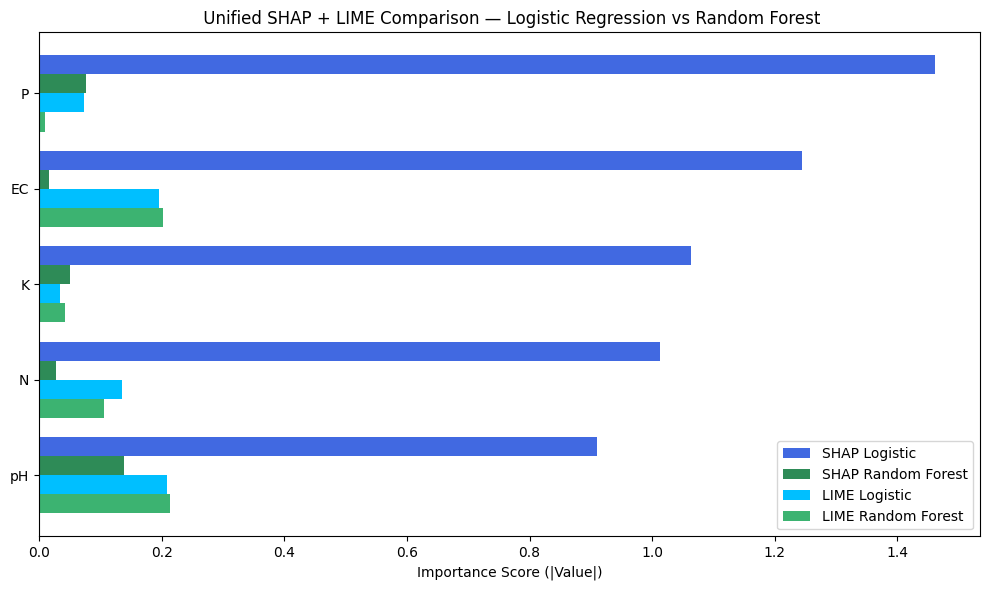

 Unified SHAP + LIME comparison plot saved → ../images/shap_lime_comparison/shap_lime_unified_comparison.png


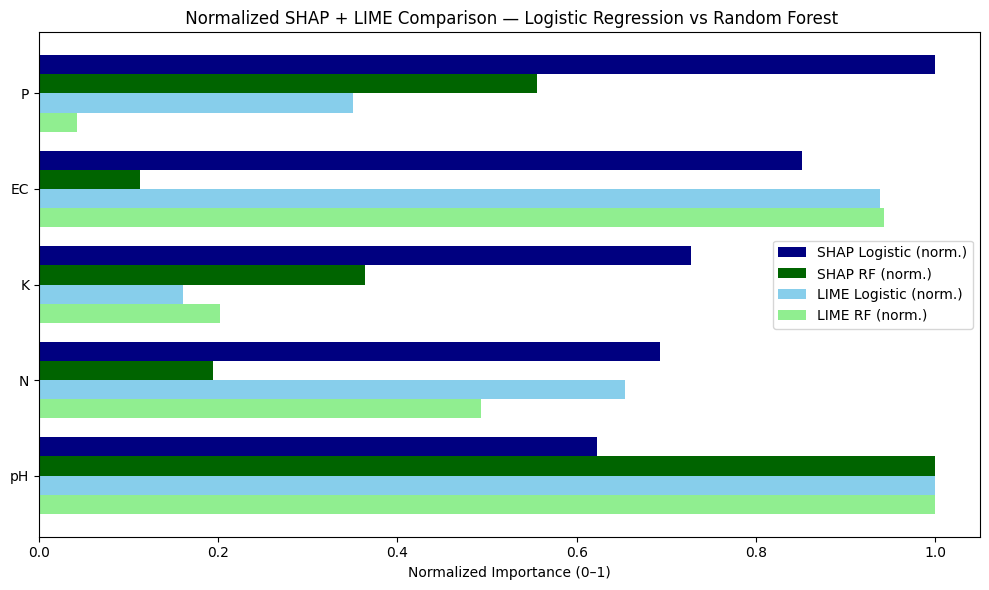

 Normalized comparison plot saved → ../images/shap_lime_comparison/shap_lime_unified_comparison_normalized.png

 All SHAP + LIME comparison plots and CSV saved successfully.


In [147]:
# ==========================================
#  Final Robust Unified SHAP + LIME Comparison
#  Logistic Regression vs Random Forest
#  Saves all plots in ../images/shap_lime_comparison/
# ==========================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from lime.lime_tabular import LimeTabularExplainer

# ==========================================
#  Dataset and Model Context
# ==========================================
feature_names = ['N', 'P', 'K', 'pH', 'EC']
class_names = [str(c) for c in sorted(np.unique(y_train))]

print(" Using features:", feature_names)
print(" Class names:", class_names)

# ==========================================
#  Global SHAP Importances
# ==========================================
# ---- Logistic Regression ----
explainer_log = shap.Explainer(log_reg, X_train_scaled)
shap_values_log = explainer_log(X_test_scaled)
mean_abs_shap_log = np.mean(np.abs(shap_values_log.values), axis=0)
if mean_abs_shap_log.ndim > 1:
    mean_abs_shap_log = mean_abs_shap_log.mean(axis=1)

# ---- Random Forest ----
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Handle multiclass safely
if isinstance(shap_values_rf, list):
    shap_values_rf_array = np.array(shap_values_rf)  # (n_classes, n_samples, n_features)
    print(" Random Forest SHAP array shape:", shap_values_rf_array.shape)
    mean_abs_shap_rf = np.mean(np.abs(shap_values_rf_array), axis=(0, 1))  # → (n_features,)
else:
    mean_abs_shap_rf = np.mean(np.abs(shap_values_rf), axis=0)

print(" Final mean_abs_shap_rf shape:", mean_abs_shap_rf.shape)
print(" mean_abs_shap_log shape:", mean_abs_shap_log.shape)

# ==========================================
#  LIME Importances (Averaged over Samples)
# ==========================================
lime_explainer = LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode='classification'
)

num_samples = 10
lime_importances_log = np.zeros(len(feature_names))
lime_importances_rf = np.zeros(len(feature_names))

for i in np.random.choice(len(X_test_scaled), num_samples, replace=False):
    # Logistic Regression
    exp_log = lime_explainer.explain_instance(
        X_test_scaled[i],
        log_reg.predict_proba,
        num_features=len(feature_names)
    )
    for f, w in exp_log.as_list():
        for feat in feature_names:
            if feat in f:
                lime_importances_log[feature_names.index(feat)] += abs(w)

    # Random Forest
    exp_rf = lime_explainer.explain_instance(
        X_test_scaled[i],
        rf.predict_proba,
        num_features=len(feature_names)
    )
    for f, w in exp_rf.as_list():
        for feat in feature_names:
            if feat in f:
                lime_importances_rf[feature_names.index(feat)] += abs(w)

lime_importances_log /= num_samples
lime_importances_rf /= num_samples
print(f"\n LIME importances computed and averaged across {num_samples} samples")

# ==========================================
#  Combine Everything
# ==========================================
print("\n🔍 Debug before combining:")
for name, arr in [
    ("Feature", feature_names),
    ("SHAP_LogReg", mean_abs_shap_log),
    ("SHAP_RandForest", mean_abs_shap_rf),
    ("LIME_LogReg", lime_importances_log),
    ("LIME_RandForest", lime_importances_rf),
]:
    print(f"{name}: type={type(arr)}, shape={np.shape(arr)}")

# Flatten
mean_abs_shap_log = np.ravel(mean_abs_shap_log)
mean_abs_shap_rf = np.ravel(mean_abs_shap_rf)
lime_importances_log = np.ravel(lime_importances_log)
lime_importances_rf = np.ravel(lime_importances_rf)

# Align lengths
lens = [len(feature_names), len(mean_abs_shap_log), len(mean_abs_shap_rf),
        len(lime_importances_log), len(lime_importances_rf)]
min_len = min(lens)
if not all(l == min_len for l in lens):
    print(f" Length mismatch detected — trimming all to {min_len}")
    feature_names = feature_names[:min_len]
    mean_abs_shap_log = mean_abs_shap_log[:min_len]
    mean_abs_shap_rf = mean_abs_shap_rf[:min_len]
    lime_importances_log = lime_importances_log[:min_len]
    lime_importances_rf = lime_importances_rf[:min_len]

# Combined DataFrame
combined_df = pd.DataFrame({
    "Feature": feature_names,
    "SHAP_LogReg": mean_abs_shap_log,
    "SHAP_RandForest": mean_abs_shap_rf,
    "LIME_LogReg": lime_importances_log,
    "LIME_RandForest": lime_importances_rf
}).sort_values(by="SHAP_LogReg", ascending=False)

print("\n Final Combined SHAP + LIME DataFrame:")
print(combined_df)

# ==========================================
#  Save Folder Setup
# ==========================================
save_dir = "../images/shap_lime_comparison"
os.makedirs(save_dir, exist_ok=True)

# Save CSV
csv_path = os.path.join(save_dir, "combined_shap_lime_logreg_rf.csv")
combined_df.to_csv(csv_path, index=False)
print(f" Combined SHAP + LIME data saved → {csv_path}")

# ==========================================
#  Visualization — Unified Comparison
# ==========================================
plt.figure(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(combined_df))

plt.barh(x - 1.5*bar_width, combined_df["SHAP_LogReg"], bar_width, label="SHAP Logistic", color="royalblue")
plt.barh(x - 0.5*bar_width, combined_df["SHAP_RandForest"], bar_width, label="SHAP Random Forest", color="seagreen")
plt.barh(x + 0.5*bar_width, combined_df["LIME_LogReg"], bar_width, label="LIME Logistic", color="deepskyblue")
plt.barh(x + 1.5*bar_width, combined_df["LIME_RandForest"], bar_width, label="LIME Random Forest", color="mediumseagreen")

plt.yticks(x, combined_df["Feature"])
plt.xlabel("Importance Score (|Value|)")
plt.title(" Unified SHAP + LIME Comparison — Logistic Regression vs Random Forest")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()

# Save unified plot
unified_path = os.path.join(save_dir, "shap_lime_unified_comparison.png")
plt.savefig(unified_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Unified SHAP + LIME comparison plot saved → {unified_path}")

# ==========================================
#  Optional: Normalized Comparison Plot
# ==========================================
combined_norm = combined_df.copy()
for col in ["SHAP_LogReg", "SHAP_RandForest", "LIME_LogReg", "LIME_RandForest"]:
    combined_norm[col] /= combined_norm[col].max()

plt.figure(figsize=(10, 6))
plt.barh(x - 1.5*bar_width, combined_norm["SHAP_LogReg"], bar_width, label="SHAP Logistic (norm.)", color="navy")
plt.barh(x - 0.5*bar_width, combined_norm["SHAP_RandForest"], bar_width, label="SHAP RF (norm.)", color="darkgreen")
plt.barh(x + 0.5*bar_width, combined_norm["LIME_LogReg"], bar_width, label="LIME Logistic (norm.)", color="skyblue")
plt.barh(x + 1.5*bar_width, combined_norm["LIME_RandForest"], bar_width, label="LIME RF (norm.)", color="lightgreen")

plt.yticks(x, combined_df["Feature"])
plt.xlabel("Normalized Importance (0–1)")
plt.title(" Normalized SHAP + LIME Comparison — Logistic Regression vs Random Forest")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()

normalized_path = os.path.join(save_dir, "shap_lime_unified_comparison_normalized.png")
plt.savefig(normalized_path, dpi=300, bbox_inches="tight")
plt.show()

print(f" Normalized comparison plot saved → {normalized_path}")
print("\n All SHAP + LIME comparison plots and CSV saved successfully.")


In [130]:
print("=== SHAP Diagnostic ===")

print("Feature names:", feature_names)
print("X_test_scaled shape:", X_test_scaled.shape)

# Logistic Regression
try:
    print("\n--- Logistic Regression ---")
    print("Raw Logistic SHAP shape:", shap_values_log.shape)
    if shap_values_log.ndim == 3:
        print("Collapsing across classes...")
        shap_values_log = shap_values_log.mean(axis=2)
    print(" Final Logistic SHAP shape:", shap_values_log.shape)
except Exception as e:
    print(" Logistic SHAP Error:", e)

# Random Forest
try:
    print("\n--- Random Forest ---")
    rf_type = type(shap_values_rf_raw)
    print(f"Type of shap_values_rf_raw: {rf_type}")

    if isinstance(shap_values_rf_raw, list):
        print(f"List length: {len(shap_values_rf_raw)} | Each element shape: {[s.shape for s in shap_values_rf_raw]}")
        shap_values_rf = np.stack(shap_values_rf_raw, axis=2)
        print("After stacking:", shap_values_rf.shape)
        shap_values_rf = shap_values_rf.mean(axis=2)
        print(" Collapsed Random Forest SHAP shape:", shap_values_rf.shape)
    else:
        print("Array shape:", shap_values_rf_raw.shape)
        shap_values_rf = np.array(shap_values_rf_raw)
        if shap_values_rf.ndim == 3:
            print("Collapsing extra dim...")
            shap_values_rf = shap_values_rf.mean(axis=2)
        print(" Final Random Forest SHAP shape:", shap_values_rf.shape)
except Exception as e:
    print(" Random Forest SHAP Error:", e)

print("\n--- Shape Alignment ---")
print("Logistic SHAP shape:", shap_values_log.shape)
print("Random Forest SHAP shape:", shap_values_rf.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print(" Should all have same number of rows (n_samples)")


=== SHAP Diagnostic ===
Feature names: ['N', 'P', 'K', 'pH', 'EC']
X_test_scaled shape: (124, 5)

--- Logistic Regression ---
Raw Logistic SHAP shape: (124, 5, 3)
 Logistic SHAP Error: 'Explanation' object has no attribute 'ndim'

--- Random Forest ---
Type of shap_values_rf_raw: <class 'numpy.ndarray'>
Array shape: (124, 5, 3)
Collapsing extra dim...
 Final Random Forest SHAP shape: (124, 5)

--- Shape Alignment ---
Logistic SHAP shape: (124, 5, 3)
Random Forest SHAP shape: (124, 5)
X_test_scaled shape: (124, 5)
 Should all have same number of rows (n_samples)



===  SHAP Dependence Grid Setup ===
 Extracted shap_values_log.values (Explanation object detected).
 Collapsed Logistic SHAP: (124, 5, 3) → (124, 5)
 Collapsed Random Forest SHAP: (124, 5, 3) → (124, 5)

===  SHAPE CHECK ===
Logistic SHAP shape: (124, 5)
Random Forest SHAP shape: (124, 5)
X_test_scaled shape: (124, 5)
Feature names: ['N', 'P', 'K', 'pH', 'EC']

===  Generating SHAP Dependence Grid ===


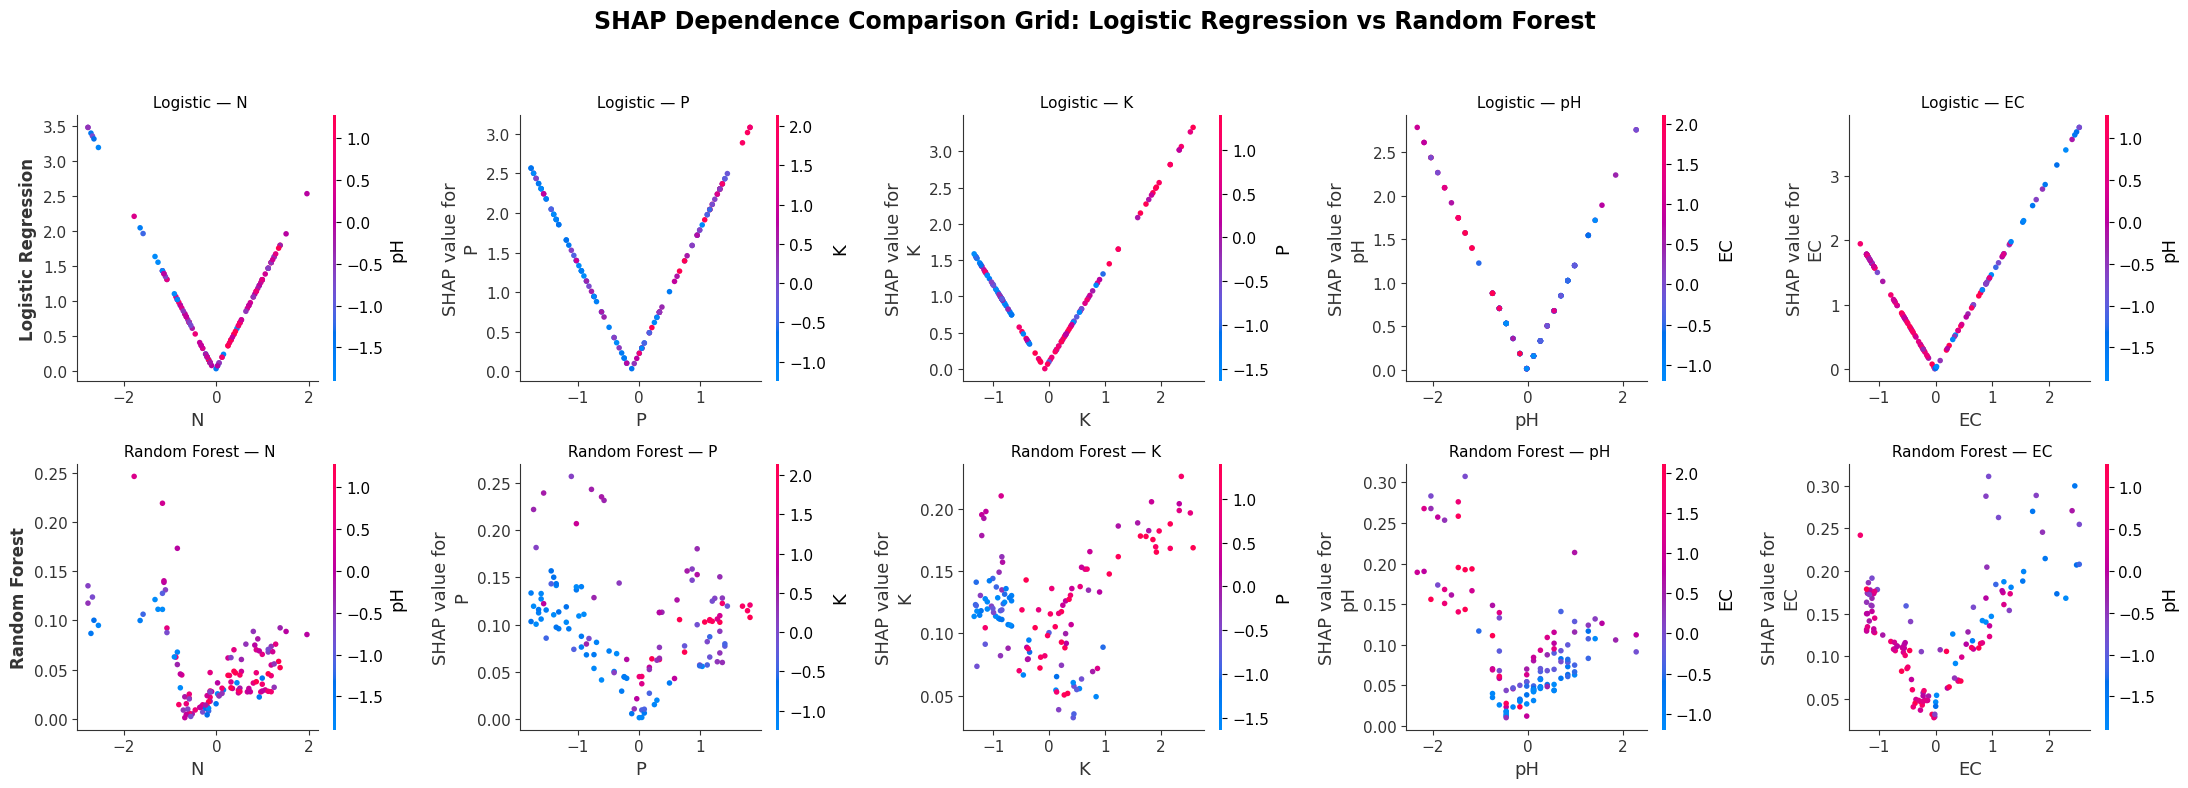

 Full grid successfully saved → ../images/shap_dependence_grid/shap_dependence_comparison_grid_final.png

===  Saving Individual SHAP Dependence Plots ===
 Saved plots for feature 'N'
 Saved plots for feature 'P'
 Saved plots for feature 'K'
 Saved plots for feature 'pH'
 Saved plots for feature 'EC'

 All SHAP dependence plots successfully saved!
 Folder: /Users/aarush/projects/soil-health-ml/images/shap_dependence_grid


In [148]:
# ======================================
#  Final Robust SHAP Dependence Grid Saver
#  Logistic Regression vs Random Forest
# ======================================

import os
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ======================================
#  PREP — Ensure Inputs Exist
# ======================================

feature_names = ['N', 'P', 'K', 'pH', 'EC']
save_dir = "../images/shap_dependence_grid"
os.makedirs(save_dir, exist_ok=True)

print("\n===  SHAP Dependence Grid Setup ===")

# --- Fix Logistic Regression SHAP ---
try:
    shap_values_log_array = shap_values_log.values  # Extract .values if Explanation object
    print(" Extracted shap_values_log.values (Explanation object detected).")
except AttributeError:
    shap_values_log_array = shap_values_log
    print(" shap_values_log is already ndarray.")

# Handle multi-class SHAP (collapse across classes)
if shap_values_log_array.ndim == 3:
    shap_values_log_fixed = np.mean(np.abs(shap_values_log_array), axis=2)
    print(f" Collapsed Logistic SHAP: {shap_values_log_array.shape} → {shap_values_log_fixed.shape}")
else:
    shap_values_log_fixed = shap_values_log_array
    print(" Logistic SHAP already 2D.")

# --- Fix Random Forest SHAP ---
if "shap_values_rf" in locals() and isinstance(shap_values_rf, np.ndarray) and shap_values_rf.ndim == 2:
    shap_values_rf_fixed = shap_values_rf
    print(" Using shap_values_rf (already 2D).")
elif "shap_values_rf_raw" in locals():
    shap_values_rf_fixed = np.mean(np.abs(shap_values_rf_raw), axis=2)
    print(f" Collapsed Random Forest SHAP: {shap_values_rf_raw.shape} → {shap_values_rf_fixed.shape}")
else:
    raise ValueError(" No valid Random Forest SHAP variable found.")

# ======================================
#  DIAGNOSTIC
# ======================================
print("\n===  SHAPE CHECK ===")
print("Logistic SHAP shape:", shap_values_log_fixed.shape)
print("Random Forest SHAP shape:", shap_values_rf_fixed.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("Feature names:", feature_names)

# ======================================
#  COLOR FEATURE MAPPING
# ======================================
def get_color_feature(values, X, feature_index):
    """Return the index of the most correlated feature for coloring."""
    try:
        correlations = np.corrcoef(X, rowvar=False)[feature_index]
        correlations[feature_index] = 0  # ignore self
        return np.argmax(np.abs(correlations))
    except Exception:
        return (feature_index + 1) % X.shape[1]  # fallback to next feature


# ======================================
#  FULL GRID COMPARISON
# ======================================
print("\n===  Generating SHAP Dependence Grid ===")

fig, axes = plt.subplots(2, len(feature_names), figsize=(22, 8))
fig.suptitle("SHAP Dependence Comparison Grid: Logistic Regression vs Random Forest", fontsize=17, fontweight="bold")

for i, feature in enumerate(feature_names):

    # --- Logistic Regression ---
    color_idx = get_color_feature(shap_values_log_fixed, X_test_scaled, i)
    shap.dependence_plot(
        i,
        shap_values_log_fixed,
        X_test_scaled,
        feature_names=feature_names,
        interaction_index=color_idx,
        ax=axes[0, i],
        show=False
    )
    axes[0, i].set_title(f" Logistic — {feature}", fontsize=11)

    # --- Random Forest ---
    color_idx = get_color_feature(shap_values_rf_fixed, X_test_scaled, i)
    shap.dependence_plot(
        i,
        shap_values_rf_fixed,
        X_test_scaled,
        feature_names=feature_names,
        interaction_index=color_idx,
        ax=axes[1, i],
        show=False
    )
    axes[1, i].set_title(f" Random Forest — {feature}", fontsize=11)

# --- Row labels ---
axes[0, 0].set_ylabel("Logistic Regression", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Random Forest", fontsize=12, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.94])

# Save the grid
grid_path = os.path.join(save_dir, "shap_dependence_comparison_grid_final.png")
plt.savefig(grid_path, dpi=300, bbox_inches="tight")
plt.show()
print(f" Full grid successfully saved → {grid_path}")

# ======================================
#  SAVE INDIVIDUAL DEPENDENCE PLOTS
# ======================================
print("\n===  Saving Individual SHAP Dependence Plots ===")

for i, feature in enumerate(feature_names):

    plt.figure(figsize=(6, 4))
    color_idx = get_color_feature(shap_values_log_fixed, X_test_scaled, i)
    shap.dependence_plot(
        i,
        shap_values_log_fixed,
        X_test_scaled,
        feature_names=feature_names,
        interaction_index=color_idx,
        show=False
    )
    plt.title(f"Logistic Regression — {feature}")
    plt.tight_layout()
    path_log = os.path.join(save_dir, f"shap_dependence_logistic_{feature}.png")
    plt.savefig(path_log, dpi=300, bbox_inches="tight")
    plt.close()

    plt.figure(figsize=(6, 4))
    color_idx = get_color_feature(shap_values_rf_fixed, X_test_scaled, i)
    shap.dependence_plot(
        i,
        shap_values_rf_fixed,
        X_test_scaled,
        feature_names=feature_names,
        interaction_index=color_idx,
        show=False
    )
    plt.title(f"Random Forest — {feature}")
    plt.tight_layout()
    path_rf = os.path.join(save_dir, f"shap_dependence_rf_{feature}.png")
    plt.savefig(path_rf, dpi=300, bbox_inches="tight")
    plt.close()

    print(f" Saved plots for feature '{feature}'")

print("\n All SHAP dependence plots successfully saved!")
print(f" Folder: {os.path.abspath(save_dir)}")


In [134]:
import builtins

print("=== POSSIBLE SHAP VARIABLES IN MEMORY (SAFE VERSION) ===")
for name, obj in list(globals().items()):  # make a copy of the dictionary
    if "shap" in name.lower() and name not in dir(builtins):
        try:
            shape = obj.shape if hasattr(obj, "shape") else f"len={len(obj)}"
        except Exception:
            shape = "?"
        print(f"{name:30} → type: {type(obj).__name__}, shape: {shape}")


=== POSSIBLE SHAP VARIABLES IN MEMORY (SAFE VERSION) ===
shap                           → type: module, shape: ?
shap_values                    → type: ndarray, shape: (124, 5, 3)
shap_values_single             → type: ndarray, shape: (5,)
shap_values_rf                 → type: ndarray, shape: (124, 5)
shap_values_rf_array           → type: ndarray, shape: (124, 5, 3)
mean_abs_shap                  → type: ndarray, shape: (5,)
all_shap                       → type: ndarray, shape: (124, 5, 2)
valid_shaps                    → type: list, shape: len=0
flatten_shap_values            → type: function, shape: ?
all_shap_flat                  → type: ndarray, shape: (124, 5)
shap_importance_df             → type: DataFrame, shape: (5, 2)
shap_vals                      → type: ndarray, shape: (124, 5, 3)
shap_array                     → type: ndarray, shape: (124, 5, 3)
shap_abs                       → type: ndarray, shape: (124, 5, 3)
shap_vals_for_plot             → type: ndarray, shape: (1

 Input arrays aligned for plotting.

 LIME Comparison DataFrame:
  Feature  Logistic Regression  Random Forest
0       N             0.136139       0.105523
1       P             0.072875       0.009149
2       K             0.033523       0.043235
3      pH             0.208271       0.214164
4      EC             0.195515       0.201894
 Saved comparison data → ../images/lime_comparison/lime_feature_weight_comparison.csv


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

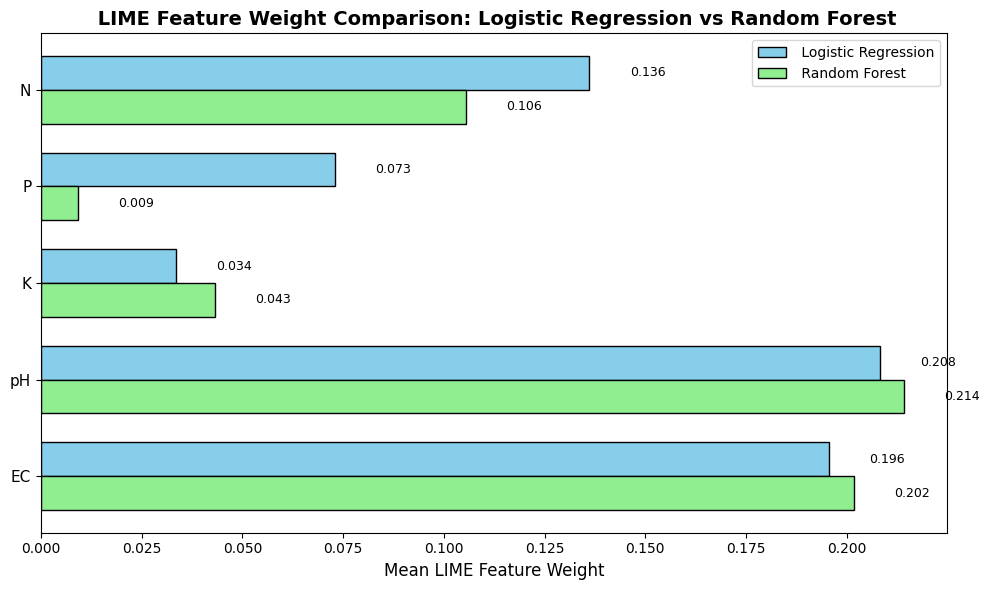

📊 LIME comparison plot saved → ../images/lime_comparison/lime_feature_weight_comparison_logreg_rf.png


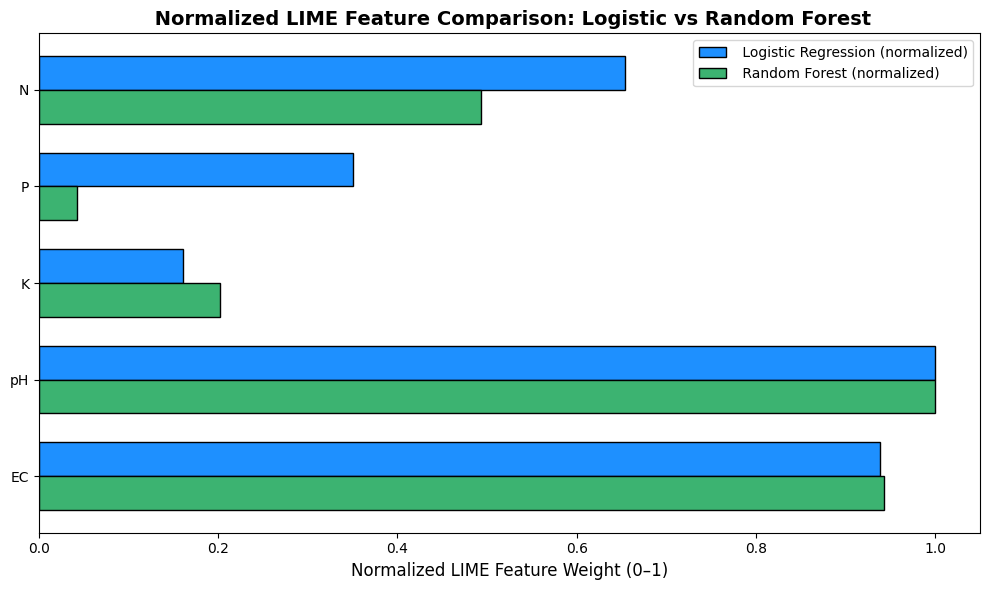

 Normalized LIME comparison plot saved → ../images/lime_comparison/lime_feature_weight_comparison_normalized.png

 All LIME feature weight comparison plots and data saved successfully.
 Folder: /Users/aarush/projects/soil-health-ml/images/lime_comparison


In [149]:
# ==========================================
#  LIME Feature Weight Comparison
#  Logistic Regression vs Random Forest
#  (Final Robust Version — Saves All Outputs)
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ Ensure Inputs Exist
# ==========================================
if "lime_importances_log" not in locals() or "lime_importances_rf" not in locals():
    raise ValueError("Missing lime_importances_log or lime_importances_rf. Run LIME explanation scripts first.")

# Ensure arrays are numpy
lime_importances_log = np.array(lime_importances_log).flatten()
lime_importances_rf = np.array(lime_importances_rf).flatten()

# Ensure same length
feature_names = np.array(feature_names)
min_len = min(len(lime_importances_log), len(lime_importances_rf), len(feature_names))
lime_importances_log = lime_importances_log[:min_len]
lime_importances_rf = lime_importances_rf[:min_len]
feature_names = feature_names[:min_len]

print(" Input arrays aligned for plotting.")

# ==========================================
#  Create Save Directory
# ==========================================
save_dir = "../images/lime_comparison"
os.makedirs(save_dir, exist_ok=True)

# ==========================================
#  Create DataFrame
# ==========================================
lime_comparison_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic Regression": lime_importances_log,
    "Random Forest": lime_importances_rf
})

print("\n LIME Comparison DataFrame:")
print(lime_comparison_df)

# Save DataFrame as CSV
csv_path = os.path.join(save_dir, "lime_feature_weight_comparison.csv")
lime_comparison_df.to_csv(csv_path, index=False)
print(f" Saved comparison data → {csv_path}")

# ==========================================
#  Plot — Side-by-Side Comparison
# ==========================================
x = np.arange(len(feature_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.barh(x - width/2, lime_importances_log, width,
                label=" Logistic Regression", color="skyblue", edgecolor="black")
bars2 = ax.barh(x + width/2, lime_importances_rf, width,
                label=" Random Forest", color="lightgreen", edgecolor="black")

# Labels
ax.set_yticks(x)
ax.set_yticklabels(feature_names, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("Mean LIME Feature Weight", fontsize=12)
ax.set_title(" LIME Feature Weight Comparison: Logistic Regression vs Random Forest", fontsize=14, fontweight="bold")
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        ax.text(width_val + np.sign(width_val)*0.01,
                bar.get_y() + bar.get_height()/2,
                f"{width_val:.3f}",
                va="center", fontsize=9)

plt.tight_layout()

# Save plot
plot_path = os.path.join(save_dir, "lime_feature_weight_comparison_logreg_rf.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"📊 LIME comparison plot saved → {plot_path}")

# ==========================================
# 5️⃣ Optional: Normalized Comparison Plot
# ==========================================
lime_comparison_norm = lime_comparison_df.copy()
for col in ["Logistic Regression", "Random Forest"]:
    lime_comparison_norm[col] /= lime_comparison_norm[col].max()

plt.figure(figsize=(10, 6))
bars1 = plt.barh(x - width/2, lime_comparison_norm["Logistic Regression"], width,
                 label=" Logistic Regression (normalized)", color="dodgerblue", edgecolor="black")
bars2 = plt.barh(x + width/2, lime_comparison_norm["Random Forest"], width,
                 label=" Random Forest (normalized)", color="mediumseagreen", edgecolor="black")

plt.yticks(x, feature_names)
plt.gca().invert_yaxis()
plt.xlabel("Normalized LIME Feature Weight (0–1)", fontsize=12)
plt.title(" Normalized LIME Feature Comparison: Logistic vs Random Forest", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()

# Save normalized plot
plot_path_norm = os.path.join(save_dir, "lime_feature_weight_comparison_normalized.png")
plt.savefig(plot_path_norm, dpi=300, bbox_inches="tight")
plt.show()
print(f" Normalized LIME comparison plot saved → {plot_path_norm}")

# ==========================================
# 6️⃣ Summary
# ==========================================
print("\n All LIME feature weight comparison plots and data saved successfully.")
print(f" Folder: {os.path.abspath(save_dir)}")


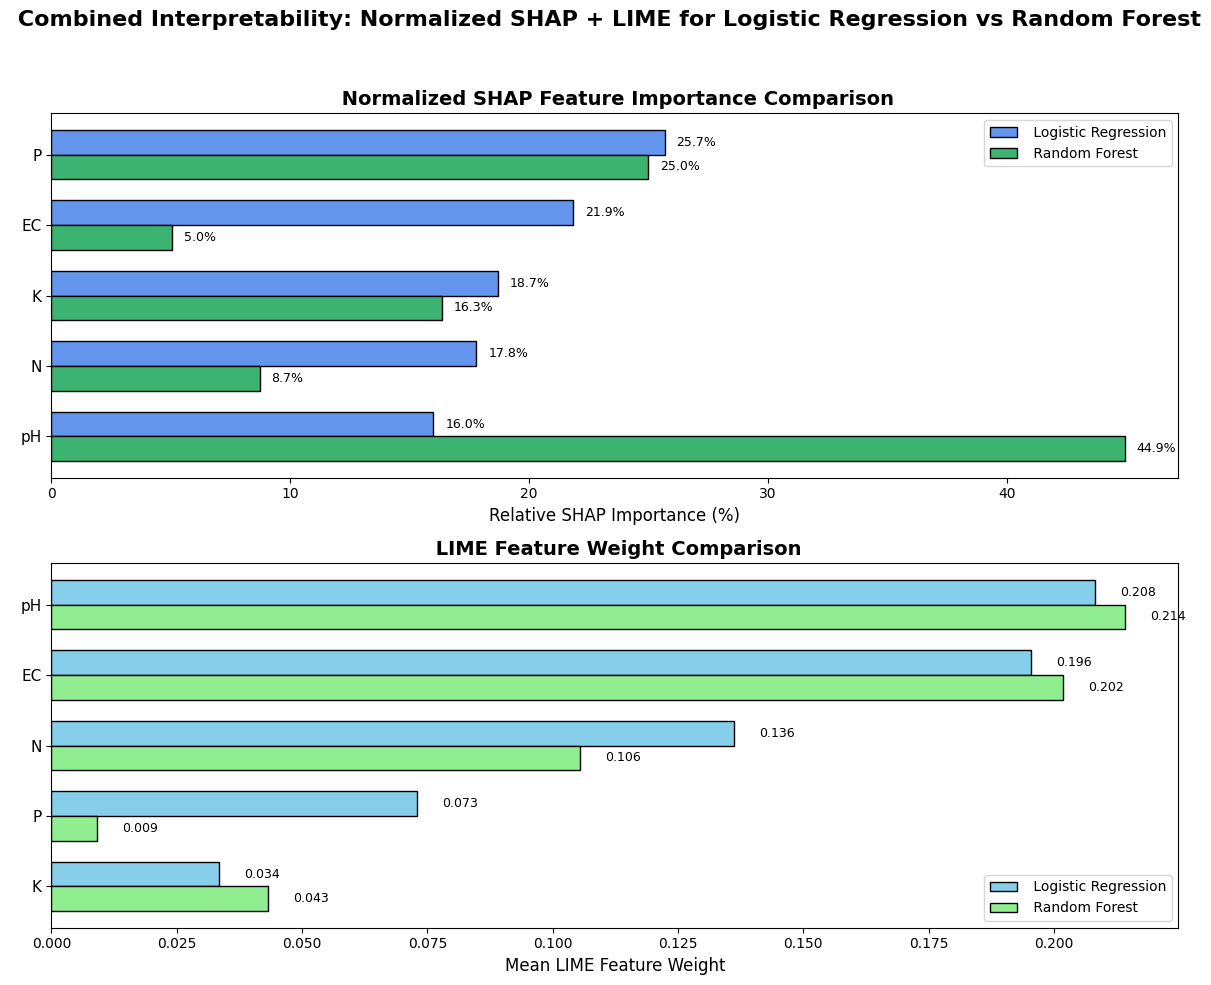


 Combined normalized interpretability plot saved as 'combined_shap_lime_logreg_rf_NORMALIZED.png'


In [155]:
# ==========================================
#  Final Normalized Combined Interpretability Visualization: SHAP + LIME
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- assume these are already defined ---
# feature_names = ['N', 'P', 'K', 'pH', 'EC']
# mean_abs_shap_log, mean_abs_shap_rf, lime_importances_log, lime_importances_rf

# Convert to numpy and flatten
mean_abs_shap_log = np.array(mean_abs_shap_log).flatten()
mean_abs_shap_rf = np.array(mean_abs_shap_rf).flatten()
lime_importances_log = np.array(lime_importances_log).flatten()
lime_importances_rf = np.array(lime_importances_rf).flatten()

# Ensure consistent length
min_len = min(len(feature_names), len(mean_abs_shap_log), len(mean_abs_shap_rf),
              len(lime_importances_log), len(lime_importances_rf))
feature_names = feature_names[:min_len]
mean_abs_shap_log = mean_abs_shap_log[:min_len]
mean_abs_shap_rf = mean_abs_shap_rf[:min_len]
lime_importances_log = lime_importances_log[:min_len]
lime_importances_rf = lime_importances_rf[:min_len]

# ======================================================
#  Normalize SHAP values for visual comparability
# ======================================================
# Each model normalized to sum = 1 (relative importance)
shap_log_norm = mean_abs_shap_log / np.sum(mean_abs_shap_log) if np.sum(mean_abs_shap_log) != 0 else mean_abs_shap_log
shap_rf_norm = mean_abs_shap_rf / np.sum(mean_abs_shap_rf) if np.sum(mean_abs_shap_rf) != 0 else mean_abs_shap_rf

# --- Convert to percentage scale (0–100%) ---
shap_log_norm *= 100
shap_rf_norm *= 100

# ======================================================
#  Prepare DataFrames
# ======================================================
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic Regression (normalized %)": shap_log_norm,
    "Random Forest (normalized %)": shap_rf_norm
}).sort_values(by="Logistic Regression (normalized %)", ascending=False)

lime_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic Regression": lime_importances_log,
    "Random Forest": lime_importances_rf
}).sort_values(by="Logistic Regression", ascending=False)

# ======================================================
#  Plot: Combined SHAP + LIME
# ======================================================
x = np.arange(len(feature_names))
width = 0.35

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# --- SHAP Comparison (normalized %) ---
bars1 = axes[0].barh(x - width/2, shap_df["Logistic Regression (normalized %)"], width,
                     label=" Logistic Regression", color="cornflowerblue", edgecolor="black")
bars2 = axes[0].barh(x + width/2, shap_df["Random Forest (normalized %)"], width,
                     label=" Random Forest", color="mediumseagreen", edgecolor="black")

axes[0].set_yticks(x)
axes[0].set_yticklabels(shap_df["Feature"], fontsize=11)
axes[0].invert_yaxis()
axes[0].set_xlabel("Relative SHAP Importance (%)", fontsize=12)
axes[0].set_title(" Normalized SHAP Feature Importance Comparison", fontsize=14, fontweight="bold")
axes[0].legend()

# Annotate SHAP values
for bars in [bars1, bars2]:
    for bar in bars:
        val = bar.get_width()
        if abs(val) > 0.001:
            axes[0].text(val + np.sign(val)*0.5, bar.get_y() + bar.get_height()/2,
                         f"{val:.1f}%", va="center", fontsize=9)

# --- LIME Comparison (absolute weights) ---
bars3 = axes[1].barh(x - width/2, lime_df["Logistic Regression"], width,
                     label=" Logistic Regression", color="skyblue", edgecolor="black")
bars4 = axes[1].barh(x + width/2, lime_df["Random Forest"], width,
                     label=" Random Forest", color="lightgreen", edgecolor="black")

axes[1].set_yticks(x)
axes[1].set_yticklabels(lime_df["Feature"], fontsize=11)
axes[1].invert_yaxis()
axes[1].set_xlabel("Mean LIME Feature Weight", fontsize=12)
axes[1].set_title(" LIME Feature Weight Comparison", fontsize=14, fontweight="bold")
axes[1].legend()

for bars in [bars3, bars4]:
    for bar in bars:
        val = bar.get_width()
        if abs(val) > 1e-6:
            axes[1].text(val + np.sign(val)*0.005, bar.get_y() + bar.get_height()/2,
                         f"{val:.3f}", va="center", fontsize=9)

# --- Layout ---
fig.suptitle(" Combined Interpretability: Normalized SHAP + LIME for Logistic Regression vs Random Forest",
             fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("combined_shap_lime_logreg_rf_NORMALIZED.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n Combined normalized interpretability plot saved as 'combined_shap_lime_logreg_rf_NORMALIZED.png'")
